In [1]:
version = 'v8base'

### Imports

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from glob import glob
import pickle, re
import time
from array import array
from scipy.interpolate import interp1d
import multiprocessing
import matplotlib.pyplot as plt
import uproot as ur
import ROOT as rt
import root_numpy as rtnp
import ROOT.RooFit as rf
from scipy.special import erf
import sys, os
import itertools
sys.path.append('../lib')
if os.environ['CMSSW_VERSION'] != 'CMSSW_10_2_3':
    raise
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel
from lumi_utilities import getLumiByTrigger

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Internal"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [3]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
webFolder = '/storage/user/ocerri/public_html/BPH_RDst/triggerScaleFactors/'+version
if not os.path.isdir(webFolder):
    print 'Creating', webFolder
    os.makedirs(webFolder)
    os.system('cp '+webFolder+'/../index.php '+webFolder+'/')

In [4]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [5]:
colors = [rt.kBlack, rt.kAzure+1, rt.kRed-4, rt.kGreen+1, rt.kViolet-7]

# Load data

In [6]:
branchesToLoad = ['mTag_pt', 'mTag_eta', 'mTag_phi', 'mTag_sigdxy',
                  'mTag_softID', 'mTag_tightID',
                  'mTag_HLT_Mu7_IP4', 'mTag_HLT_Mu9_IP6', 'mTag_HLT_Mu12_IP6',
                  'mProbe_pt', 'mProbe_eta', 'mProbe_phi', 'mProbe_sigdxy', 
                  'mProbe_softID', 'mProbe_tightID',
                  'mProbe_HLT_Mu7_IP4', 'mProbe_HLT_Mu9_IP6', 'mProbe_HLT_Mu12_IP6',
                  'deltaR_tagProbe', 'massMuMu', 'vtx_isGood', 'massMuMu_refit',
                  'prescaleMu7_IP4', 'prescaleMu9_IP6', 'prescaleMu12_IP6', 'nVtx',
                 ]

In [7]:
def loadDF(loc, branches):
    dfL = []
    for l in loc: 
        print l
        dfL.append(pd.DataFrame(rtnp.root2array(l, branches=branches)))
    if len(dfL) == 1:
        return dfL[0]
    else:
        return pd.concat(dfL)

In [8]:
dataDir = '../data/cmsRD'
RDdsLoc = glob(dataDir + '/ParkingBPH*/Run2018D-05May2019promptD-v1_RDntuplizer_TagAndProbeTrigger_210209_CAND.root')
dfRD = loadDF(RDdsLoc, branchesToLoad)
print 'Data probe muons:', dfRD.shape[0]

../data/cmsRD/ParkingBPH3/Run2018D-05May2019promptD-v1_RDntuplizer_TagAndProbeTrigger_210209_CAND.root
../data/cmsRD/ParkingBPH2/Run2018D-05May2019promptD-v1_RDntuplizer_TagAndProbeTrigger_210209_CAND.root
../data/cmsRD/ParkingBPH5/Run2018D-05May2019promptD-v1_RDntuplizer_TagAndProbeTrigger_210209_CAND.root
../data/cmsRD/ParkingBPH4/Run2018D-05May2019promptD-v1_RDntuplizer_TagAndProbeTrigger_210209_CAND.root
../data/cmsRD/ParkingBPH1/Run2018D-05May2019promptD-v1_RDntuplizer_TagAndProbeTrigger_210209_CAND.root
Data probe muons: 28292553


In [9]:
mcDir = '../data/cmsMC_private/BP_Tag-Probe_B0_JpsiKst_Hardbbbar_evtgen_HELAMP_PUc0_10-2-3'
MCdsLoc = glob(mcDir + '/ntuples_TagAndProbeTrigger_Jpsi/merged/out_CAND.root')
dfMC = loadDF(MCdsLoc, branchesToLoad + ['sfMuonID'])
print 'MC probe muons:', dfMC.shape[0]

../data/cmsMC_private/BP_Tag-Probe_B0_JpsiKst_Hardbbbar_evtgen_HELAMP_PUc0_10-2-3/ntuples_TagAndProbeTrigger_Jpsi/merged/out_CAND.root
MC probe muons: 6181283


In [10]:
class pileupReweighter(object):
    def __init__(self, mcSkimFile, cat, histoName='hAllNvtx', dataDate='200515'):
        loc = '../data/cmsRD/ParkingBPH{}/'+'Run2018D-05May2019promptD-v1_RDntuplizer_PrescaleVertices_{}_CAND.root'.format(dataDate)
        fAuxPileupRD = []

        hPileupTarget = None

        for i in range(1, 6):
            fAuxPileupRD.append(rt.TFile.Open(loc.format(i), 'READ'))
            if hPileupTarget is None:
                hPileupTarget = fAuxPileupRD[-1].Get('nVtx/hNvtxPassed'+cat.trg).Clone()
            else:
                hPileupTarget.Add(fAuxPileupRD[-1].Get('nVtx/hNvtxPassed'+cat.trg))

        hPileupTarget.Scale(1./hPileupTarget.Integral())

        fAuxPileupMC = rt.TFile.Open(mcSkimFile, 'READ')
        hPileupGen = fAuxPileupMC.Get(histoName)

        weights = np.ones(hPileupGen.GetNbinsX())
        s = 0
        for i in range(weights.shape[0]):
            if hPileupGen.GetBinContent(i+1) == 0:
                continue
            weights[i] = hPileupTarget.GetBinContent(i+1)/(hPileupGen.GetBinContent(i+1)/hPileupGen.Integral())
            s += (hPileupGen.GetBinContent(i+1)/hPileupGen.Integral()) * weights[i]

        self.weightsPileupMC = weights/s

        for f in fAuxPileupRD + [fAuxPileupMC]:
            f.Close()

    def getPileupWeights(self, arrNvtx, selection=None):
        x = arrNvtx
        if not selection is None:
            x = x[selection]
        return self.weightsPileupMC[x.astype(np.int)]

In [11]:
class Bauble(object):
    pass

for trg in ['Mu7_IP4', 'Mu9_IP6', 'Mu12_IP6']:
    aux = Bauble()
    aux.trg = trg
    puRew = pileupReweighter(MCdsLoc[0], aux, histoName='TnP/hAllNvts')
    nMax = np.max(dfMC['nVtx'])
    while nMax > (puRew.weightsPileupMC.shape[0] - 1):
        puRew.weightsPileupMC = np.append(puRew.weightsPileupMC, puRew.weightsPileupMC[-1])
        print trg, puRew.weightsPileupMC.shape
    dfMC['w'+trg] = puRew.weightsPileupMC[dfMC['nVtx'].astype(np.int)]

In [12]:
# trg = 'Mu12_IP6'

# h_list = []
# sel = dfRD['prescale'+trg] > 0.5
# h = create_TH1D(dfRD['nVtx'][sel], name='h',
#                 title='Data',
#                 axis_title=['# vertextes', 'Normalized Events'],
#                 binning=[60, 0.5, 60.5],
#                )
# h_list.append(h)

# sel = dfMC['prescale'+trg] > 0.5
# h = create_TH1D(dfMC['nVtx'][sel], name='h2', title='MC PUc0', 
#                 weights=dfMC['w'+trg],
#                 binning=h_list[0].binning)
# h_list.append(h)

# leg = rt.TLegend(0.77, 0.75, 0.95, 0.93)
# leg.SetBorderSize(0)
# for i, h in enumerate(h_list):
#     h.SetLineColor(colors[i])
#     h.SetMarkerColor(colors[i])
#     h.Sumw2()
#     h.Scale(1./h.Integral())
#     leg.AddEntry(h, h.GetTitle(), 'lep')
# m = SetMaxToMaxHist(h_list)
# h_list[0].SetTitle('')

# c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')
# leg.Draw()
# c.Draw()

Explore kinematic distribution to choose a binning

In [13]:
def plot(var, binning, xtitle, logx=False, logy=False, ymin=1e-5, selRD=None, selMC=None):
    h_list = []
    x = dfRD[var]
    if not selRD is None:
        x = x[selRD]
    print 'data yield: {:1.2e}'.format(x.shape[0])
    h = create_TH1D(x, name='h',
                    title='Data',
                    axis_title=[xtitle, 'Normalized Events'],
                    binning=binning,
                    opt='underflow,overflow'
                   )
    h_list.append(h)

    x = dfMC[var]
    if not selMC is None:
        x = x[selMC]
    print 'MC yield: {:1.2e}'.format(x.shape[0])
    h = create_TH1D(x, name='h2', title='MC PUc0', binning=h_list[0].binning,opt='underflow,overflow')
    h_list.append(h)

    leg = rt.TLegend(0.77, 0.75, 0.95, 0.93)
    leg.SetBorderSize(0)
    for i, h in enumerate(h_list):
        h.SetLineColor(colors[i])
        h.SetMarkerColor(colors[i])
        h.Sumw2()
        h.Scale(1./h.Integral())
        leg.AddEntry(h, h.GetTitle(), 'lep')
    m = SetMaxToMaxHist(h_list)
    h_list[0].GetYaxis().SetRangeUser(ymin, m)
    h_list[0].SetTitle('')

    c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')
    leg.Draw()
    c.Draw()
    if logy:
        c.SetLogy()
    if logx:
        c.SetLogx()
    return [c, leg, h_list]

In [19]:
probeTrigger = 'HLT_Mu12_IP6'

sel = {}

for n, df in zip(['MC', 'RD'], [dfMC, dfRD]):
    selTot = np.logical_and(df['mProbe_softID'] > 0.5, df['prescale'+probeTrigger[4:]] > 0)
    selTot = np.logical_and(selTot, df['deltaR_tagProbe'] > 0.3)
    selTot = np.logical_and(selTot, df['vtx_isGood'] > 0.5)
    selTot = np.logical_and(selTot, np.abs(df['massMuMu_refit'] - 3.09691) < 0.1)
    sel[n] = selTot

data yield: 1.05e+07
MC yield: 3.41e+06


[<ROOT.TCanvas object ("c") at 0xc5eb740>,
 <ROOT.TLegend object ("TPave") at 0xc5af640>,
 [<ROOT.TH1D object ("h") at 0x22e72f0>,
  <ROOT.TH1D object ("h2") at 0xc60d500>]]

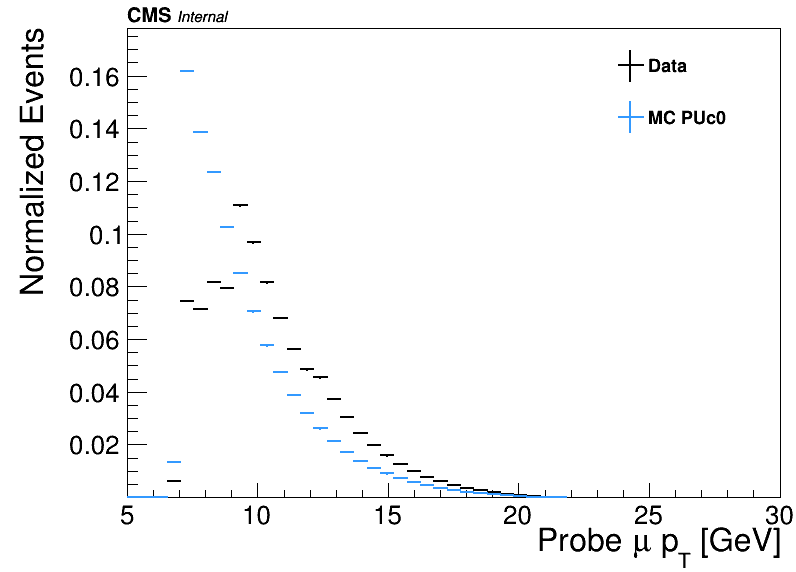

In [20]:
plot('mTag_pt', np.linspace(start=5, stop=30, num=50), 
     selRD=sel['RD'], selMC=sel['MC'],
     xtitle='Probe #mu p_{T} [GeV]', 
     logx=False, logy=False)

data yield: 1.05e+07
MC yield: 3.41e+06


[<ROOT.TCanvas object ("c") at 0xc61ac60>,
 <ROOT.TLegend object ("TPave") at 0xb14a7a0>,
 [<ROOT.TH1D object ("h") at 0xc5a66a0>,
  <ROOT.TH1D object ("h2") at 0xb14a120>]]

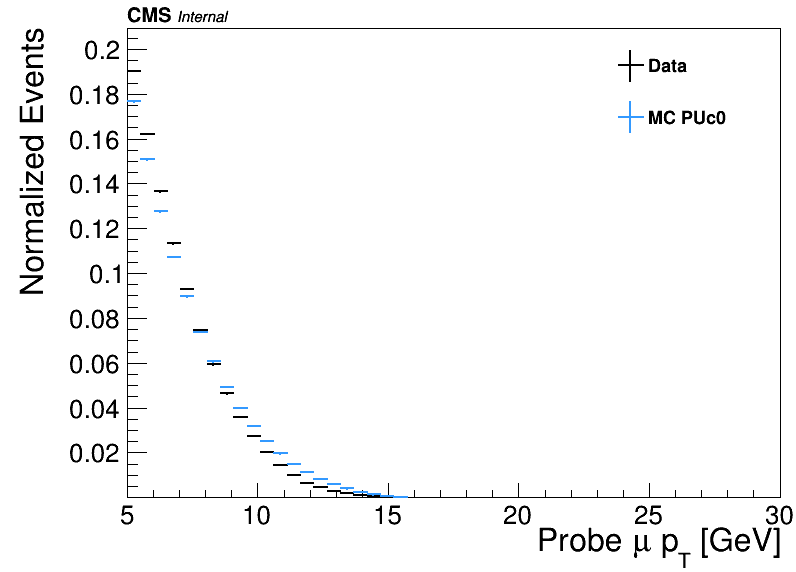

In [21]:
plot('mProbe_pt', np.linspace(start=5, stop=30, num=50), 
     selRD=sel['RD'], selMC=sel['MC'],
     xtitle='Probe #mu p_{T} [GeV]', 
     logx=False, logy=False)

In [ ]:
plot('mProbe_sigdxy', np.logspace(start=0, stop=3, num=50), 'Probe #mu d_{xy}/#sigma_{d_{xy}}', logx=True, logy=False);

In [ ]:
plot('massMuMu', np.linspace(start=2.85, stop=3.3, num=100), 'mass(#mu#mu) [GeV]', logx=False, logy=False);

In [ ]:
plot('massMuMu_refit', np.linspace(start=2.85, stop=3.3, num=100), 'mass(#mu#mu) refit [GeV]',
     selRD=dfRD['vtx_isGood']>0, selMC=dfMC['vtx_isGood']>0,
     logx=False, logy=False);

In [ ]:
plot('mProbe_eta', np.linspace(start=-2, stop=2, num=100), 'Probe #mu #eta', logx=False, logy=False)

In [ ]:
plot('deltaR_tagProbe', 
     np.linspace(start=0, stop=0.6, num=50), 
#      np.logspace(start=-2, stop=np.log10(0.6), num=100), 
     '#Delta R (#mu tag, #mu probe)', logx=False, logy=False, ymin=1e-6);

In [ ]:
plot('mTag_HLT_Mu7_IP4', 
     [2, -0.5, 1.5], 
     'mTag_HLT_Mu7_IP4', logx=False, logy=False, ymin=1e-6);

In [ ]:
plot('mTag_sigdxy', 
     np.logspace(start=0, stop=3, num=50), 
     'Tag #mu d_{xy}/#sigma_{d_{xy}}', logx=True, logy=False);